# Homework: Not So Basic Artificial Neural Networks

Your task is to implement a simple framework for convolutional neural networks training. While convolutional neural networks is a subject of lecture 3, we expect that there are a lot of students who are familiar with the topic.

In order to successfully pass this homework, you will have to:

- Implement all the blocks in `homework_modules.ipynb` (esp `Conv2d` and `MaxPool2d` layers). Good implementation should pass all the tests in `homework_test_modules.ipynb`.
- Settle with a bit of math in `homework_differentiation.ipynb`
- Train a CNN that has at least one `Conv2d` layer, `MaxPool2d` layer and `BatchNormalization` layer and achieves at least 97% accuracy on MNIST test set.

Feel free to use `homework_main-basic.ipynb` for debugging or as source of code snippets. 

Note, that this homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook with cnn trained
- `homework_modules.ipynb`
- `homework_differentiation.ipynb`

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [2]:
# (re-)load layers
%run homework_modules.ipynb

In [3]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [4]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()  # your dataset

In [5]:
import numpy.typing as npt

def one_hot(labels: npt.NDArray, num_classes: int = 10):
    result = np.zeros((labels.size, num_classes))
    result[np.arange(labels.size), labels] = 1
    return result

y_test_labels = y_test

y_train = one_hot(y_train)
y_val = one_hot(y_val)
y_test = one_hot(y_test)

X_train = X_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]
X_val = X_val[:, np.newaxis]

In [6]:
print(X_train.shape)

(50000, 1, 28, 28)


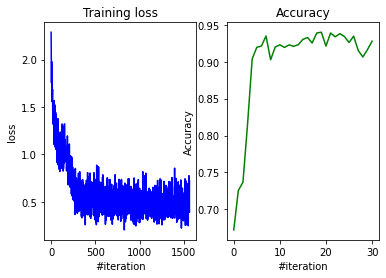

Current loss: 0.721006
Current accuracy: 0.927800


 22%|█████████▎                                | 86/390 [02:32<52:32, 10.37s/it]

In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

model = Sequential()
model.add(Conv2d(1, 3, 3))
model.add(MaxPool2d(2))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout())
model.add(Conv2d(3, 6, 3))
model.add(MaxPool2d(2))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout())
model.add(Flatten())
model.add(Linear(294, 64))
model.add(ReLU())
model.add(Linear(64, 10))
model.add(ReLU())
model.add(SoftMax())

model.train()

criterion = ClassNLLCriterionUnstable()

optimizer_config = {'learning_rate' : 1e-2, 'beta1': 0.8, 'beta2': 0.8, 'epsilon': 1e-8}
optimizer_state = {}

epochs = 5
batch_size = 128
log_every = 50

loss_history = []
accuracy = []

step = 1
for epoch in range(1, epochs + 1):
    for x_batch, y_batch in tqdm(get_batches((X_train, y_train), batch_size), total=len(X_train) // batch_size):
        model.zeroGradParameters()

        predictions = model.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        model.backward(x_batch, dp)

        # Update weights
        adam_optimizer(model.getParameters(), 
                     model.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      

        loss_history.append(loss)

        if step % log_every == 0:
            model.evaluate()
            predictions = model.forward(X_test)
            score = accuracy_score(y_test_labels, predictions.argmax(axis=1))
            accuracy.append(score)
            model.train()
        step += 1

    display.clear_output(wait=True)

    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title("Training loss")
    ax1.set_xlabel("#iteration")
    ax1.set_ylabel("loss")

    ax2.set_title("Accuracy")
    ax2.set_xlabel("#iteration")
    ax2.set_ylabel("Accuracy")

    ax1.plot(loss_history, 'b')
    ax2.plot(accuracy, 'g')
    plt.show()

    print('Current loss: %f' % loss) 
    print('Current accuracy: %f' % score)

Print here your accuracy on test set. It should be >97%. Don't forget to switch the network in 'evaluate' mode